In [86]:
from sklearn.metrics import mean_squared_error
from math import sqrt # rms = sqrt(mean_squared_error(y_true, y_predicted))
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd

# input dataset
rew = pd.read_csv("REW_dataset.csv")

#get required columns
cols = list(rew.columns)

type_list = cols[cols.index('House'):cols.index('Multifamily')+1]

area_list = cols[cols.index('Whalley'):cols.index('Pitt Meadows Rural')+1]

postal_list = cols[cols.index('V3S'):cols.index('V0Y')+1]

features_list = cols[cols.index('Drapes/window Coverings'):cols.index('Vacuum Blt. In')+1]

In [110]:
# subset area df=df['area'==]
# type_list has house types
# cols used
req_cols = ['price','listing_id','bed','bath','area_sqft','fireplaces']+type_list

rew = rew[req_cols]

# Data Used for recommendation
rew.head(2)

,price,listing_id,bed,bath,area_sqft,fireplaces,House,Apt/Condo,Townhouse,Land/Lot,Duplex,Mfd/Mobile Home,Multifamily
0,399800,R2333259,2,2.0,1208.0,1.0,0,0,1,0,0,0,0
1,2550000,R2277753,4,6.0,3312.0,1.0,1,0,0,0,0,0,0


In [88]:
#Input Data Creation

samp_price = 1000000

samp_bed = 3 

samp_bath = 2

samp_area_sqft = 1500

samp_fireplaces = 1

# use a drop down - type of house
samp_ptype = "House"

sample_df = pd.DataFrame({"price":samp_price,"bed":samp_bed,"bath":samp_bath,\
                          "area_sqft":samp_area_sqft,"fireplaces":samp_fireplaces},index=[0])

sample_df[samp_ptype]=1

type_cols = set(type_list)-(set({samp_ptype}))

for col in type_cols:
    sample_df[col]=0

#Columns Used - reorder  
sample_df = sample_df[['price', 'bed', 'bath', 'area_sqft', 'fireplaces', 'House', 'Apt/Condo',
       'Townhouse', 'Land/Lot', 'Duplex', 'Mfd/Mobile Home', 'Multifamily']]

#Input DF    
sample_df

,price,bed,bath,area_sqft,fireplaces,House,Apt/Condo,Townhouse,Land/Lot,Duplex,Mfd/Mobile Home,Multifamily
0,1000000,3,2,1500,1,1,0,0,0,0,0,0


In [89]:
# rew data without listing_id
sim_data = rew[['price','listing_id','bed','bath','area_sqft','fireplaces']+type_list]
sim_data = sim_data.drop('listing_id', axis=1)

#Add this row on top of all records
sim_numeric = pd.concat([sample_df, sim_data], axis=0)

#Normalize
sim_normal = (sim_numeric - sim_numeric.min()) / (sim_numeric.max() - sim_numeric.min())

#Normalized sample
normal_sample = sim_normal.iloc[0,:]

#normalized sim_data
sim_normal = sim_normal.iloc[1:,:]

In [90]:
from sklearn.neighbors import NearestNeighbors

#train model
nbrs = NearestNeighbors(n_neighbors=30, metric='euclidean',algorithm='auto').fit(sim_normal)

In [91]:
import pickle
# now you can save it to a file
with open('knn_model.pkl', 'wb') as f:
    pickle.dump(nbrs, f)

# and later you can load it
with open('knn_model.pkl', 'rb') as f:
    loaded_model_knn = pickle.load(f)

In [92]:
# get model results on smaple data
vals = loaded_model_knn.kneighbors([normal_sample])

# get indices
indices = list(vals[1][0])

indices[:10]

[13198, 10817, 4093, 9981, 4729, 13894, 13157, 3267, 2608, 12570]

In [93]:
sample_df

,price,bed,bath,area_sqft,fireplaces,House,Apt/Condo,Townhouse,Land/Lot,Duplex,Mfd/Mobile Home,Multifamily
0,1000000,3,2,1500,1,1,0,0,0,0,0,0


In [94]:
# KNN - 30 Similar records
returned_records = rew.iloc[indices,:]
returned_records.head()

,price,listing_id,bed,bath,area_sqft,fireplaces,House,Apt/Condo,Townhouse,Land/Lot,Duplex,Mfd/Mobile Home,Multifamily
13198,949900,R2342400,3,2.0,1487.0,1.0,1,0,0,0,0,0,0
10817,919000,R2322129,3,2.0,1500.0,1.0,1,0,0,0,0,0,0
4093,1025000,R2336953,3,2.0,1438.0,1.0,1,0,0,0,0,0,0
9981,930000,R2347880,3,2.0,1546.0,1.0,1,0,0,0,0,0,0
4729,995000,R2333224,3,2.0,1426.0,1.0,1,0,0,0,0,0,0


In [95]:
# required listing Ids
returned_records['listing_id'][:3]

13198    R2342400
10817    R2322129
4093     R2336953
Name: listing_id, dtype: object

In [96]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
transformed = pd.DataFrame(pca.fit_transform(sim_data))

transformed.head()

,0,1
0,-1.204548e+06,-203.994339
1,9.456531e+05,782.131102
2,-1.205548e+06,-396.474336
3,-5.063480e+05,-861.985174
4,-1.053476e+05,-307.461407


In [97]:
#transformed1 = pd.DataFrame(pca.fit_transform(sample_df))

df1 = pd.concat([sample_df, returned_records.drop('listing_id', axis=1)], axis=0)


In [98]:
transformed2 = pd.DataFrame(pca.fit_transform(df1))

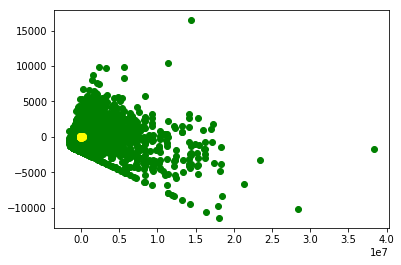

In [99]:
import matplotlib.pyplot as plt

plt.scatter(transformed[0], transformed[1], label='All points', c='green')
plt.scatter(transformed2[0][0], transformed2[1][0], label='All points', c='red')
plt.scatter(transformed2[0][1:], transformed2[1][1:], label='All points', c='yellow')

plt.show()

In [116]:
import plotly.offline as pyo
import plotly.graph_objs as go

# Create a trace
trace0 = go.Scatter(
    x = transformed[0],
    y = transformed[1],
    mode = 'markers',
    name = 'All records',
    marker = dict(
        size = 5,
        color = '#A8DCE6',
)
)

trace1 = go.Scatter(
    x = [transformed2[0][0]],
    y = [transformed2[1][0]],
    mode = 'markers',
    name = 'Sample record',
    marker = dict(
        size = 10,
        color = 'red',
)
)

trace2 = go.Scatter(
    x = transformed2[0][1:], 
    y = transformed2[1][1:],
    mode = 'markers',
    name = 'Nearest Neighbours',
    marker = dict(
        size = 9,
        color = 'green',
)
)

data = [trace0,trace2,trace1]

layout = dict(title = 'All Property Records in 2-Dimensional Space',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False)
             )

fig = dict(data=data, layout=layout)

# Plot and embed in ipython notebook!
pyo.plot(fig, filename='KNN-scatter')

'file://C:\\Users\\RohithSooramPC\\Downloads\\BigA\\CMPT-733-Project - My Changes\\data\\KNN-scatter.html'